<a href="https://colab.research.google.com/github/DanielSchussmann/Seminar/blob/master/Seminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### $$\text{Machine Learning updates} $$


####$$\text{ Variables}$$ 

$$ i = \text{parameter for the layer}$$
$$ j,l= \text{parameter for the position inside the i-th layer}$$
$$ b_{i,j} = \text{Bias of neuron} $$

$$ x_{i,j} = \text{input value / fireing rate}$$
$$ w_{i,j,l} = \text{weight of connection, k and l are destination neuron}$$
$$\sigma = \text{activation function}$$
$$n_i = \text{number of neurons in the i-th layer}$$

(add illustration for clarification)

$$x_{i+1,j} = \sigma [\sum_{j=1}^{n_i}(w_{(i,j,l)}^T * x_{i,j}) +b_{i+1,j}] \text{(not a recursive expression)}$$
$$ .\\.\\.\\ x_{1,1} = \sigma [\sum_{j=1}^{n_0}(w_{(0,j,1)}^T * x_{0,j}) +b_{1,1}] \\ $$
$$ x_{2,4} = \sigma [\sum_{j=1}^{n_1}(w_{(1,j,4)}^T * x_{1,j}) +b_{2,4}] \\ $$

###DATA

####RELATIONSHIP SHOWCASE

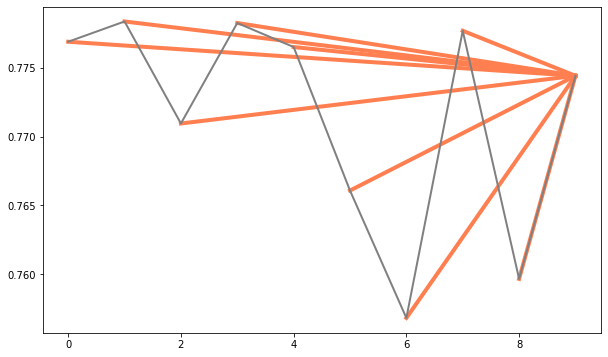

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
x = np.random.uniform(low=0.750, high=0.780, size=(10,))

plt.figure(figsize=(10, 6))
def last_relation(x):
    output = []
    for j in range(0,len(x)-1):
            output.append(x[-1]/x[j])
            plt.plot([len(x)-1, j], [x[-1], x[j]], color='coral', linewidth=4)
    return output
last_relation(x)
plt.plot(x,color='gray',linewidth=2)
plt.show()

In [ ]:
def mean_movement(inputfile,columns):
    data = pd.read_csv(inputfile, usecols=columns)
    df = data.copy()

    df = np.array(np.array_split(df, int(len(df) / 10))).reshape([int(len(df) / 10), 10])  # testing examples
    x_raw = df.copy()
    for i in range(0, len(df)):
        df[i]=normalize(df[i])

    x_norm = df[::2]
    y_norm = []
    for i in range(0, len(df[1::2])):
        y_norm.append(np.mean(df[1::2][i]))

    return [x_norm, y_norm, df,x_raw]

#CodeSnippets


###Backtesting

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
!pip uninstall plotly==4.4.1 -y
!pip install  plotly==5.4.0
import plotly
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
"""!pip install dash
import dash"""
print(plotly.__version__)
class BACKTEST():
    def __init__(self): #Innitializing all the required variables
        self.analytics=[]
        self.portfolio = 10000
        self.order_size=200
        self.leverage=50
        self.index=0
        self.order_id=1
        self.data=0
        self.draw_data=0
        self.open_orders=[]
        self.ohlc:np.array #OPENHIGHLOWCLOSE
        self.break_index=15

    def tick(self): #tick reffers to receiving a new candle from the market
        if len(self.open_orders) >= 1:
            self._TrackOrders()
        self.index+=1
        self.ohlc=self.data[self.index]

    def MakeOrder(self,type,tp,sl):
        buy_price=self.ohlc[-1]
        #"activating" order
        break_id=0
        exe_id=self.index
        self.open_orders.append([type,tp,sl,buy_price,exe_id,break_id])


    def _TrackOrders(self):
        for j in range(len(self.open_orders)):
            current_order=self.open_orders[j]
            type=current_order[0]
            tp=current_order[1]
            sl=current_order[2]
            buy_price=current_order[3]
            id=current_order[4]

            if type=='BUY':
                #Check wether or not the order is closed by tp or sl
                if tp <= self.ohlc[1]:# if tp is smaller than high
                    self.portfolio+=abs(tp-buy_price)*self.order_size*self.leverage
                    self.open_orders.pop(j) #close order
                    self.analytics.append([id,self.index,type+' / TP',buy_price,tp,sl,self.portfolio])
                    break
                elif sl>=self.ohlc[2]:# if sl is greater than low
                    self.portfolio -= abs(sl - buy_price) * self.order_size * self.leverage
                    self.open_orders.pop(j)
                    self.analytics.append([id,self.index,type+' / SL',buy_price,tp,sl,self.portfolio])
                    break #break the loop to stop index from becoming out of range
                elif self.open_orders[j][5]==self.break_index: #break order after 10 ticks
                    self.portfolio += (self.ohlc[3] - buy_price) * self.order_size * self.leverage
                    self.open_orders.pop(j)
                    self.analytics.append([id,self.index,type+' / TIMED_OUT',buy_price, tp, sl, self.portfolio])
                    break

            elif type=='SELL':
                if tp >= self.ohlc[2]:  # if tp is greater than low
                    self.portfolio += abs(tp - buy_price) * self.order_size * self.leverage
                    self.open_orders.pop(j)  # close order
                    self.analytics.append([id,self.index,type+' / TP',buy_price,tp,sl,self.portfolio])
                    break
                elif sl <= self.ohlc[1]:  # if sl is smaller than high
                    self.portfolio -= abs(sl - buy_price) * self.order_size * self.leverage
                    self.open_orders.pop(j)
                    self.analytics.append([id,self.index,type+' / SL',buy_price,tp,sl,self.portfolio])
                    break
                elif self.open_orders[j][5]==self.break_index: #break order after 10 ticks
                    self.portfolio += (buy_price-self.ohlc[3]) * self.order_size * self.leverage
                    self.open_orders.pop(j)
                    self.analytics.append([id,self.index,type+' / TIMED_OUT', buy_price, tp, sl, self.portfolio])
                    break
            self.open_orders[j][5]+=1

    def visualize(self):
        init_notebook_mode(connected=True) 
        fig_1 = go.Figure(data=[go.Candlestick(
            open=self.draw_data['Open'][0:self.index],
            high=self.draw_data['High'][0:self.index],
            low=self.draw_data['Low'][0:self.index],
            close=self.draw_data['Close'][0:self.index], name='price',opacity=0.8)],layout_title_text='Trades overview')

        statistics =np.transpose(self.analytics)
        portfolio = statistics[-1].astype('float32')
        fig_2 = go.Figure(data=[go.Scatter(x=np.arange(0, len(portfolio)), y=portfolio,)],layout_title_text='Portfolio Evolution')

        exe_type, count = np.unique(statistics[2], return_counts=True)

        colors=['#884EA0','#A569BD','#D7BDE2','#138D75','#AF7AC5','#A3E4D7']
        fig_3= go.Figure(data=[go.Pie(values=count,labels=exe_type,marker_colors = colors,hole = 0.4)],layout_title_text='Order type Distribution')
        #fig.add_trace(go.Scatter(
        #    x=np.arange(0, len(close)), y=close, line=dict(color='blue', width=2), name='order'))
        for j in range(0,len(self.analytics)):
            orders=self.analytics[j]
            start=orders[0]
            end=orders[1]
            o_type=orders[2]
            buy_price=orders[3]
            tp=orders[4]
            sl=orders[5]


            fig_1 .add_shape(type="rect", #POSITIVE RANGE
                      xref="x", yref="y",
                      x0=start, y0=tp if o_type[0:3]=='BUY' else buy_price, # To minimize code length
                      x1=end, y1=buy_price if o_type[0:3]=='BUY' else tp,
                      line=dict(color="#22754B", width=1),fillcolor="#80D9D3", opacity=0.3)
            fig_1 .add_shape(type="rect", #NEGATIVE RANGE
                          xref="x", yref="y",
                          x0=start, y0=sl if o_type[0:3]=='BUY' else buy_price,
                          x1=end, y1=buy_price if o_type[0:3]=='BUY' else sl,
                          line=dict(color="#752222", width=1),fillcolor="#D78E65",opacity=0.3)
            fig_1 .add_shape(type="line",
                          xref="x", yref="y",
                          x0=start, y0=buy_price,x1=end, y1=buy_price,
                          line=dict(color="#752222", width=1,dash="dashdot"),)

        """app.layout = dash.html.Div(children=[

            dash.html.H1(children='BACKTESTING SUMMARY'),
            dash.dcc.Graph(id='Full order overview',figure=fig_1,style={'width': '98vw', 'height': '85vh'}),
            dash.dcc.Graph(id='Portfolio development',figure=fig_2),
            dash.dcc.Graph(id='Trade eval',figure=fig_3),
        ])"""
        iplot([fig_1, fig_2,fig_3])
        
        



Found existing installation: plotly 5.4.0
Uninstalling plotly-5.4.0:
  Successfully uninstalled plotly-5.4.0
  Using cached plotly-5.4.0-py2.py3-none-any.whl (25.3 MB)


5.4.0


In [ ]:
import tensorflow as tf

def normalize(inp):
    A = [i*i for i in inp]
    v = (sum(A))**(0.5)
    A = [i / v for i in inp]
    return A
nn=BACKTEST()
nn.data=np.array(pd.read_csv('/content/drive/MyDrive/seminar_data/AUD_CHF.csv',usecols=[1,2,3,4]))
nn.tick()



nn.leverage=500
nn.break_index=10
for j in range(0,40):
    gathered_data=[]
    look=[]
    for i in range(0,10):
        gathered_data.append(nn.ohlc[3])
        nn.tick()


    normalized_data = normalize(gathered_data)
    prediction_data=[normalized_data,normalized_data]

    A = [i * i for i in gathered_data]  # denormalization of data
    deNorm = (sum(A)) ** (0.5)  # denormalization of data

    pred = tf.keras.models.load_model('/content/drive/MyDrive/seminar_data/mean_direction')
    prediction=np.array(pred(np.array(prediction_data[0:1])))[0][0]*deNorm


    richt_preis=nn.ohlc[3]

    risk=0.01

    if richt_preis< prediction:
        tp = richt_preis * (1 + risk)
        sl = richt_preis * (1 - risk/2)
        nn.MakeOrder('BUY',tp,sl)
    elif richt_preis>prediction:
        tp = richt_preis * (1 - risk)
        sl = richt_preis * (1 + risk/2)
        nn.MakeOrder('SELL',tp,sl)

nn.draw_data=pd.read_csv('/content/drive/MyDrive/seminar_data/AUD_CHF.csv',usecols=[1,2,3,4])
nn.visualize()



ValueError: ignored

###Transpose Grouping

In [ ]:
import tensorflow as tf
import numpy as np
f=[[10, 1, 'BUY/TP', '[0.73193 0.73003 0.72849 0.7286 ]', 0.728706654182939, 0.7284933458170609, 10010.665418293898],
[20, 2, 'BUY/SL', '[0.73085 0.73126 0.73077 0.73112]', 0.73122719822575, 0.7310128017742499, 10021.385240868898],
[30, 3, 'SELL/TP', '[0.73121 0.73155 0.73109 0.73154]', 0.731432904132646, 0.7316470958673539, 10032.0948276043],
[40, 4, 'BUY/TP', '[0.73028 0.73037 0.72721 0.728  ]', 0.7281067002559689, 0.727893299744031, 10042.764853201194],
[50, 5, 'SELL/TP', '[0.72974 0.73159 0.72974 0.73041]', 0.730303703101363, 0.730516296898637, 10053.39454306489],
[60, 6, 'SELL/SL', '[0.73477 0.73538 0.73398 0.73406]', 0.7339521205357381, 0.734167879464262, 9242.606596638696],
[70, 7, 'SELL/TP', '[0.73614 0.73644 0.73566 0.73597]', 0.7358617637605858, 0.7360782362394142, 10053.430220580121],
[80, 8, 'SELL/TP', '[0.73337 0.73537 0.73328 0.73506]', 0.7349521138215329, 0.7351678861784672, 10164.218838426834],
[90, 9, 'SELL/TP', '[0.73586 0.73632 0.73569 0.73622]', 0.7361121845429743, 0.7363278154570256, 9800.000384129398]]
print(f)

print(np.transpose(f))

[[10, 1, 'BUY/TP', '[0.73193 0.73003 0.72849 0.7286 ]', 0.728706654182939, 0.7284933458170609, 10010.665418293898], [20, 2, 'BUY/SL', '[0.73085 0.73126 0.73077 0.73112]', 0.73122719822575, 0.7310128017742499, 10021.385240868898], [30, 3, 'SELL/TP', '[0.73121 0.73155 0.73109 0.73154]', 0.731432904132646, 0.7316470958673539, 10032.0948276043], [40, 4, 'BUY/TP', '[0.73028 0.73037 0.72721 0.728  ]', 0.7281067002559689, 0.727893299744031, 10042.764853201194], [50, 5, 'SELL/TP', '[0.72974 0.73159 0.72974 0.73041]', 0.730303703101363, 0.730516296898637, 10053.39454306489], [60, 6, 'SELL/SL', '[0.73477 0.73538 0.73398 0.73406]', 0.7339521205357381, 0.734167879464262, 9242.606596638696], [70, 7, 'SELL/TP', '[0.73614 0.73644 0.73566 0.73597]', 0.7358617637605858, 0.7360782362394142, 10053.430220580121], [80, 8, 'SELL/TP', '[0.73337 0.73537 0.73328 0.73506]', 0.7349521138215329, 0.7351678861784672, 10164.218838426834], [90, 9, 'SELL/TP', '[0.73586 0.73632 0.73569 0.73622]', 0.7361121845429743, 0.

#Noramlization

In [ ]:
import tensorflow as tf

raw_data = [5.48813504, 7.15189366, 6.02763376, 5.44883183, 4.23654799, 6.45894113, 4.37587211, 8.91773001, 9.63662761, 3.83441519]


#--Normalizing-without-any-libraries-------------------------------

def normalize(inp):
    A = [i*i for i in inp]
    v = (sum(A))**(0.5)
    A = [i / v for i in inp]
    return A


print(normalize(raw_data))
#--Normalizing-with-Tensorflow-------------------------------------
print(tf.keras.utils.normalize(raw_data))




[0.2699883994478898, 0.3518368823309622, 0.296528999279228, 0.26805488092407004, 0.20841666662128538, 0.3177471336085864, 0.2152707064525075, 0.4387070716299857, 0.4740731861618412, 0.18863377311626361]
[[0.2699884  0.35183688 0.296529   0.26805488 0.20841667 0.31774713
  0.21527071 0.43870707 0.47407319 0.18863377]]


####RELATIONSHIP OF NORMALIZED DATA

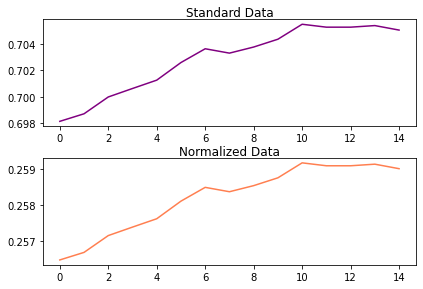

In [ ]:
#Normalization does not change data relationships
import matplotlib.pyplot as plt
x =[0.69814,0.69871,0.69998,0.70062,0.70125,0.70258,0.70362,0.70329,0.70375,0.70434,0.70547,0.70525,0.70525,0.70537,0.70503]

x_norm= normalize(x)
fig, (ax1, ax2) = plt.subplots(2)
fig.tight_layout()
ax1.plot(x,color="purple")
ax1.set_title('Standard Data', fontsize=12,pad=-14)
ax2.plot(x_norm,color="coral")
ax2.set_title('Normalized Data', fontsize=12,pad=-14)
plt.show()


####DENORMALIZATION

In [ ]:
#Showcase denormalization
def deNorm(x,set):
  A = [i * i for i in set]
  deNorm = (sum(A)) ** (0.5)
  return x*deNorm

normalized = normalize(raw_data)[0]
denormalized = deNorm(normalized,raw_data)

print(raw_data[0],normalized,denormalized)

5.48813504 0.2699883994478898 5.48813504


In [ ]:
#Calculation with the prices takes ages, not suitable for backtesting....

import numpy as np
import pandas as pd
data=np.array(pd.read_csv('/content/drive/MyDrive/seminar_data/AUD_CHF.csv',usecols=[4])).reshape((6936))[:400]
#print(np.round_(data,3))
def forward_fib(input):

    output = []
    for x in range(0,70):
        end=len(input)
        X=input[0]
        for a in range(x+1,end):
            A=input[a]
            for b in range(a+1,end):
                B=input[b]
                XB=abs(1-((B-X)/(A-X)))
                if 0.382 <= XB <= 0.618:

                    #output.append("____________________________\n XB:= "+str(XB) + ' at index:'+str(b))
                    for c in range(b+1,end):
                        C=input[c]
                        AC = (C - B) / (A - B)
                        if 0.382 <= AC <= 0.886:
                            #output.append(" AC:= "+str(AC) + ' at index:'+str(c))
                            for d in range(c+1,end):
                                D=input[d]
                                BD=(D-C)/(B-C)
                                XD=1 - ((D - X) / (A - X))
                                if 2.24 <= BD <= 3.618 and  1.618<= XD <= 1.618500:
                                    #output.append(' BD:= '+str(BD)+' at index:'+str(d)+ '\n XD:= '+str(XD)+' at index:'+str(d))
                                    output.append([[x,X],[a,A],[b,B],[c,C],[d,D],[XB,AC,BD,XD]])
    return output
#forward_fib([1.20731,1.21640 ,1.21110,1.310,1.20872,1.211940,1.21192,1.21110,1.20779,])

print(forward_fib(data),len(forward_fib(data)))

KeyboardInterrupt: ignored

In [295]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
data_read=pd.read_csv('/content/drive/MyDrive/seminar_data/AUD_NZD.csv',usecols=[1,2,3,4])[:600]
data=np.array(data_read['Close']).reshape((len(data_read)))
#X and A given
def XA_single():
  X=1.16244
  A= 1.17420 
  #BAT EX RE
  XB=0.388 #=> A [,]
  AC=0.855
  BD=4.71
  XD=1.617
  #hypothetically max(data)
  B=-(XB-1)*(A-X)+X
  C=AC*(A-B)+B
  D=BD*(B-C)+C

  print(X,A,B,C,D)
#XB=abs(round(1-((B-X)/(A-X)),3))
#AC=abs(round(((C-B)/(A-B)),3))
#BD=abs(round(((D-C)/(B-C)),3))
#XD=abs(1-round(((D-X)/(A-X)),3))
# output should be A=[x,y],B=[x,y],C=[x,y],D[x,y]
def XA_range(data):
  XB=[0.382,0.618] #=> A [,]
  AC=[0.382,0.886] 
  BD=[2.24,3.618]
  XD=[1.6175,1.6181]
  dist=10
  output=[]
  check=[]
  for x in range(0,len(data)):
    X=data[x]
    for a in range(x+1,len(data)):
      A=data[a] 
      B=[-(XB[1]-1)*(A-X)+X,-(XB[0]-1)*(A-X)+X]
      #output.append('B',[B[0],B[-1]])
      C=[AC[0]*(A-B[0])+B[0] ,AC[0]*(A-B[1])+B[1], AC[1]*(A-B[0])+B[0] , AC[1]*(A-B[1])+B[1]]
      #output.append('C1',[C[0],C[-1]])
      C=[min(C),max(C)]
      #output.append('C2',C)
      D=[-(XD[1]-1)*(A-X)+X,-(XD[0]-1)*(A-X)+X] #D=BD*(B-C)+C
      #output.append( 'D2',[D[0],D[-1]])
      D=[min(D),max(D)]
      #output.append('D1',D)
      
      #output.append('--------------------------------')
      b=np.array(np.where(np.logical_and(B[0]<=data[x+a:x+a+dist], data[x+a:x+a+dist]<=B[1])))
      if b.size!=0:
        b_range=np.array(x+a+b)[0]
        b=x+a+b[0][0]
        c=np.array(np.where(np.logical_and(C[0]<=data[b:b+dist], data[b:b+dist]<=C[1])))
        if c.size!=0:
          c_range=(b+c)[0]
          c=b+c[0][0]
          #print(x,a,b,c)
          d=np.array(np.where(np.logical_and(D[0]<=data[c+1:c+dist], data[c+1:c+dist]<=D[1])))
          if d.size!=0:
            d_range=np.array([c+d])[0]
            d=c+d[0][0]
            check.append([x,a,b_range,c_range,d_range])
  
  for i in range(0,len(check)):
    current_check=check[i]
    x=[]
    y=[]
    X_i=current_check[0]
    A_i=current_check[1]
    C_i=current_check[3][0]
    D_i=current_check[4][0][0]

    
    XB=[0.382,0.618] #=> A [,]
    AC=[0.382,0.886] 
    BD=[2.24,3.618]
    XD=[1.6175,1.6181]
    #XB=abs(round(1-((B-X)/(A-X)),3))
    #AC=abs(round(((C-B)/(A-B)),3))
    #BD=abs(round(((D-C)/(B-C)),3))
    #XD=abs(1-round(((D-X)/(A-X)),3))
    X=data[X_i]
    A=data[A_i]
    D=data[D_i]
    
    C=data[C]
    B=data[B]
    
    x.append([X_i,A_i,C_i,D_i])
    y.append([X,A,B,C,D])
    output.append([x,y])
  
  return output   


f=XA_range(data)


fig_1 = go.Figure(data=[go.Candlestick(
            open=data_read['Open'],
            high=data_read['High'],
            low=data_read['Low'],
            close=data_read['Close'], name='price',opacity=0.8)],layout_title_text='Trades overview')








p=f[0]
print(p)
fig_1.add_trace(go.Scatter(x=[p[0][0][0],p[0][0][1],p[0][0][2],None,p[0][0][2],p[0][0][3],p[0][0][4]], y=[p[1][0][0],p[1][0][1],p[1][0][2],None,p[1][0][2],p[1][0][3],p[1][0][4]], fill="toself"))


fig_1.update_layout(xaxis_rangeslider_visible=False)
fig_1.show()


IndexError: ignored

In [237]:
import numpy as np
data =np.array([90,20,3,4,51,2,5,122,1])
if np.array(np.where(np.logical_and(data>=0, data<=1))).size !=0:
  print(data[1+1:])

print(np.array(np.argwhere(np.logical_and(data>=0, data<=1)))[0].size)

#print(np.argwhere( 50<=data.any() and data.any() <= 52))

[  3   4  51   2   5 122   1]
1


In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
data_read=pd.read_csv('/content/drive/MyDrive/seminar_data/AUD_NZD.csv',usecols=[1,2,3,4])[:600]
data=np.array(data_read['']).reshape((len(data_read)))
#X and A given
def XA_single():
  X=1.16244
  A= 1.17420 
  #BAT EX RE
  XB=0.388 #=> A [,]
  AC=0.855
  BD=4.71
  XD=1.617
  #hypothetically max(data)
  B=-(XB-1)*(A-X)+X
  C=AC*(A-B)+B
  D=BD*(B-C)+C

  print(X,A,B,C,D)
#XB=abs(round(1-((B-X)/(A-X)),3))
#AC=abs(round(((C-B)/(A-B)),3))
#BD=abs(round(((D-C)/(B-C)),3))
#XD=abs(1-round(((D-X)/(A-X)),3))
# output should be A=[x,y],B=[x,y],C=[x,y],D[x,y]
def XA_range(data):
  XB=[0.382,0.618] #=> A [,]
  AC=[0.382,0.886] 
  BD=[2.24,3.618]
  XD=[1.6175,1.6181]
  dist=10
  output=[]
  check=[]
  for x in range(0,len(data)):
    X=data[x]
    for a in range(x+1,len(data)):
      A=data[a] 
      B=[-(XB[1]-1)*(A-X)+X,-(XB[0]-1)*(A-X)+X]
      #output.append('B',[B[0],B[-1]])
      C=[AC[0]*(A-B[0])+B[0] ,AC[0]*(A-B[1])+B[1], AC[1]*(A-B[0])+B[0] , AC[1]*(A-B[1])+B[1]]
      #output.append('C1',[C[0],C[-1]])
      C=[min(C),max(C)]
      #output.append('C2',C)
      D=[-(XD[1]-1)*(A-X)+X,-(XD[0]-1)*(A-X)+X] #D=BD*(B-C)+C
      #output.append( 'D2',[D[0],D[-1]])
      D=[min(D),max(D)]
      #output.append('D1',D)
      
      #output.append('--------------------------------')
      b=np.array(np.where(np.logical_and(B[0]<=data[x+a:x+a+dist], data[x+a:x+a+dist]<=B[1])))
      if b.size!=0:
        b_range=np.array(x+a+b)[0]
        b=x+a+b[0][0]
        c=np.array(np.where(np.logical_and(C[0]<=data[b:b+dist], data[b:b+dist]<=C[1])))
        if c.size!=0:
          c_range=(b+c)[0]
          c=b+c[0][0]
          #print(x,a,b,c)
          d=np.array(np.where(np.logical_and(D[0]<=data[c+1:c+dist], data[c+1:c+dist]<=D[1])))
          if d.size!=0:
            d_range=np.array([c+d])[0]
            d=c+d[0][0]
            check.append([x,a,b_range,c_range,d_range])
  
  for i in range(0,len(check)):
    current_check=check[i]
    x=[]
    y=[]
    X_i=current_check[0]
    A_i=current_check[1]
    C_i=current_check[3][0]
    D_i=current_check[4][0][0]

    
    XB=[0.382,0.618] #=> A [,]
    AC=[0.382,0.886] 
    BD=[2.24,3.618]
    XD=[1.6175,1.6181]
    #XB=abs(round(1-((B-X)/(A-X)),3))
    #AC=abs(round(((C-B)/(A-B)),3))
    #BD=abs(round(((D-C)/(B-C)),3))
    #XD=abs(1-round(((D-X)/(A-X)),3))
    X=data[X_i]
    A=data[A_i]
    D=data[D_i]
    
    C=data[C]
    B=data[B]
    
    x.append([X_i,A_i,C_i,D_i])
    y.append([X,A,B,C,D])
    output.append([x,y])
  
  return output   


f=XA_range(data)


fig_1 = go.Figure(data=[go.Candlestick(
            open=data_read['Open'],
            high=data_read['High'],
            low=data_read['Low'],
            close=data_read['Close'], name='price',opacity=0.8)],layout_title_text='Trades overview')








p=f[0]
print(p)
fig_1.add_trace(go.Scatter(x=[p[0][0][0],p[0][0][1],p[0][0][2],None,p[0][0][2],p[0][0][3],p[0][0][4]], y=[p[1][0][0],p[1][0][1],p[1][0][2],None,p[1][0][2],p[1][0][3],p[1][0][4]], fill="toself"))


fig_1.update_layout(xaxis_rangeslider_visible=False)
fig_1.show()
